**환경에 대한 정의 : Maze**
- state_to_pos : state는 스칼라 값인 반면, pos는 벡터이다. 두 값 사이의 변환이 필요하다.
- pos_to_state : 위 과정의 역 과정이다.
- take_action : state에서 action을 취했을 때 결과를 출력한다. 장애물이나 미로 밖으로 갔을 때는 -1, False 를 반환하고, goal에 도달했을 때는 1, True를 출력한다.

In [8]:
import numpy as np

class Maze:
    def __init__(self):
        self.maze = np.zeros((5, 5))
        self.maze[1, 1] = -1  # obstacle
        self.maze[3, 3] = -1  # obstacle
        self.maze[4, 4] = 1   # goal

    def state_to_pos(self, state):
        return (state // 5, state % 5)

    def pos_to_state(self, pos):
        return pos[0] * 5 + pos[1]

    def take_action(self, state, action):
        x, y = self.state_to_pos(state)

        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1

        if x < 0 or x >= 5 or y < 0 or y >= 5:
            return state, -1, False

        if self.maze[x, y] == -1:
            return state, -1, False

        if self.maze[x, y] == 1:
            return self.pos_to_state((x, y)), 1, True

        return self.pos_to_state((x, y)), 0, False
    def print_maze(self, now_pos=False):
        if now_pos != False :
            temp = self.maze[now_pos[0]][now_pos[1]]
            self.maze[now_pos[0]][now_pos[1]] = 2
        for row in self.maze:
            printed_row = []
            for cell in row:
                if cell == 0:
                    printed_row.append(' ')
                elif cell == 1:
                    printed_row.append('G')  # Goal
                elif cell == -1:
                    printed_row.append('O')  # Obstacle
                elif cell == 2 :
                    printed_row.append('P')
            print('|' + '|'.join(printed_row) + '|')
        print()
        if now_pos != False :
            self.maze[now_pos[0]][now_pos[1]] = temp

**학습 부분**
1. 필요한 파라미터와 State, Action, Reward 등을 초기화
2. 시작 state로부터 앱실론 그리디를 통하여 액션을 취함
3. action을 실행하여 환경으로부터, 다음 state, reward, done을 받음
4. Q테이블 업데이트 (식은 아래 첨부)
5. done=True 라면 종료, 에피소드를 재시작
6. Q테이블이 수렴되면 종료 (아래 코드에서는 10000번 실행시 수렴한다고 가정)
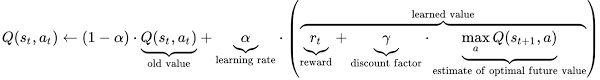

In [9]:
# q_learning.py
import numpy as np

alpha = 0.5
gamma = 0.6
epsilon = 0.1
num_episodes = 10000

num_states = 25  
num_actions = 4  
Q_table = np.zeros((num_states, num_actions)) # 처음에는 0으로 초기화되어있는 Q테이블

maze = Maze()

for i_episode in range(num_episodes):
    state = 0  
    done = False
    if i_episode % 1000 == 0 :
        print(i_episode, "완료")
    while not done:  
        # 앱실론 그리디
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice(num_actions)  
        else:
            action = np.argmax(Q_table[state])  
        # action 실횅
        next_state, reward, done = maze.take_action(state, action)
        # Q테이블 업데이트
        Q_table[state, action] = (1 - alpha) * Q_table[state, action] \
                                + alpha * (reward + gamma * np.max(Q_table[next_state]))
        # state를 다음 state로
        state = next_state
print("학습 완료")

0 완료
1000 완료
2000 완료
3000 완료
4000 완료
5000 완료
6000 완료
7000 완료
8000 완료
9000 완료
학습 완료


첫 업데이트가 오래 걸리는 이유에 대한 생각 : goal의 위치까지 가는 경우의 수가 많기 때문일 것이다. 처음 업데이트가 완료된다면 이후에는 Q테이블이 편향을 갖게 되어 빠른 속도가 나올 것이다. 한 스탭 당 음의 reward를 주면 더 빠르게 학습이 되지 않을까? (밑에서 구현해봄)

**업데이트된 Q테이블 테스트**

In [10]:
# Test the trained agent
state = 0
done = False
x = 0
y = 0
pos = (x, y)
while not done:
    maze.print_maze(pos)
    action = np.argmax(Q_table[state])  # 학습단계와 다르게 앱실론 그리디를 하지 않는다.
    next_state, reward, done = maze.take_action(state, action) 
    state = next_state  

    x, y = maze.state_to_pos(state)
    pos = (x, y)
    print(f"Agent moved to position: ({x}, {y})")
    
    if done and reward == 1:
        print("goal에 도착")
    elif done and reward == -1:
        print("장애물에 도착")

|P| | | | |
| |O| | | |
| | | | | |
| | | |O| |
| | | | |G|

Agent moved to position: (0, 1)
| |P| | | |
| |O| | | |
| | | | | |
| | | |O| |
| | | | |G|

Agent moved to position: (0, 2)
| | |P| | |
| |O| | | |
| | | | | |
| | | |O| |
| | | | |G|

Agent moved to position: (1, 2)
| | | | | |
| |O|P| | |
| | | | | |
| | | |O| |
| | | | |G|

Agent moved to position: (2, 2)
| | | | | |
| |O| | | |
| | |P| | |
| | | |O| |
| | | | |G|

Agent moved to position: (2, 3)
| | | | | |
| |O| | | |
| | | |P| |
| | | |O| |
| | | | |G|

Agent moved to position: (2, 4)
| | | | | |
| |O| | | |
| | | | |P|
| | | |O| |
| | | | |G|

Agent moved to position: (3, 4)
| | | | | |
| |O| | | |
| | | | | |
| | | |O|P|
| | | | |G|

Agent moved to position: (4, 4)
goal에 도착


결과 : 장애물을 피하고 적절히 goal에 도착한다.

**---------------------------------------------------------------------------------------**  
**다른 미로에 관하여**  
랜덤으로 미로를 생성하고 그에 따른 해결 방법 도출

In [4]:
class Maze:
    def __init__(self):
        self.size = 20
        self.maze = np.zeros((self.size, self.size))
        # 미로 랜덤 생성
        for i in range(100) :
            self.maze[np.random.randint(0, self.size)][np.random.randint(0, self.size)] = -1
        self.maze[0, 0] = 0
        self.maze[self.size-1, self.size-1] = 1   

    def state_to_pos(self, state):
        return (state // self.size, state % self.size)

    def pos_to_state(self, pos):
        return pos[0] * self.size + pos[1]

    def take_action(self, state, action):
        x, y = self.state_to_pos(state)

        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1

        if x < 0 or x >= self.size or y < 0 or y >= self.size:
            return state, -1, False

        if self.maze[x, y] == -1:
            return state, -1, False

        if self.maze[x, y] == 1:
            return self.pos_to_state((x, y)), 1, True
        # 일정 구간의 반복이 있길래 시간이 지날수록 음의 reward를 받도록 하였다.
        return self.pos_to_state((x, y)), -0.01, False 
    def print_maze(self, now_pos=False):
        if now_pos != False :
            temp = self.maze[now_pos[0]][now_pos[1]]
            self.maze[now_pos[0]][now_pos[1]] = 2
        for row in self.maze:
            printed_row = []
            for cell in row:
                if cell == 0:
                    printed_row.append(' ')
                elif cell == 1:
                    printed_row.append('G') 
                elif cell == -1:
                    printed_row.append('O')  
                elif cell == 2 :
                    printed_row.append('P')
            print('|' + '|'.join(printed_row) + '|')
        print()
        # 경로가 보여지도록 아래의 코드를 지움
        #if now_pos != False :
        #    self.maze[now_pos[0]][now_pos[1]] = temp

In [5]:
# 랜덤으로 생성되는 미로
maze = Maze()
maze.print_maze()
# 골에 도달할 방법이 없을 수도 있기 때문에 확인할 수 있어야함

| | | |O| |O|O|O|O|O| | | | | | | | |O| |
| | | |O|O| | | | | |O| | |O| | | | | |O|
| |O| | | | | | | |O| | | | | | | | | |O|
| |O| | | |O| | | | |O| | | | | |O|O| | |
| |O| |O| | | | | | | | |O|O| | | | | | |
| | | | | | |O| | | | | | | | | | | | |O|
| | |O| | | |O| | | | | | |O| |O|O| | | |
| | | | |O| | | |O| |O|O| | | | | | | | |
| |O| | | | |O| | | | |O| | | | |O| | | |
| | |O|O| | | |O|O| | | | | | | | | | | |
|O| | | | |O| | | | |O| | | | | | | |O| |
|O|O|O| |O| | | | | | |O|O| | | | | | | |
| | | | | |O|O| | | | | | |O| |O| |O|O| |
|O| | | | | | | | | |O| |O|O|O| | | | |O|
| | |O| | | |O| | | | | |O| | |O| | | | |
| |O| |O|O|O| | |O| | | |O|O| | | | | | |
| | |O| | | | | | | | | | | | | | |O| | |
|O| | | | | | | | |O| |O| | | | | |O|O| |
| | | | |O| | | | | | | | | | | |O| | | |
| | | | | | | | |O| | | | | | |O| | | |G|



In [6]:
import numpy as np

alpha = 0.5
gamma = 0.6
epsilon = 0.1
num_episodes = 10000
size = maze.size
num_states = size*size # state의 수는 10 * 10개 이다.  
num_actions = 4 # action의 수는 변하지 않는다.
Q_table = np.zeros((num_states, num_actions)) 

pos = (0, 0)
for i_episode in range(num_episodes):
    state = 0  
    done = False
    if i_episode % 1000 == 0 :
        print(i_episode, "완료")
    while not done:  
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice(num_actions)  
        else:
            action = np.argmax(Q_table[state])  
        x, y = maze.state_to_pos(state)
        pos = (x, y)
        next_state, reward, done = maze.take_action(state, action)
        Q_table[state, action] = (1 - alpha) * Q_table[state, action] \
                                + alpha * (reward + gamma * np.max(Q_table[next_state]))
        state = next_state
print("학습 완료")

0 완료
1000 완료
2000 완료
3000 완료
4000 완료
5000 완료
6000 완료
7000 완료
8000 완료
9000 완료
학습 완료


In [7]:
state = 0
done = False
x = 0
y = 0
pos = (x, y)
while not done:
    maze.print_maze(pos)
    action = np.argmax(Q_table[state])  # 학습단계와 다르게 앱실론 그리디를 하지 않는다.
    next_state, reward, done = maze.take_action(state, action) 
    state = next_state  

    x, y = maze.state_to_pos(state)
    pos = (x, y)
    print(f"Agent moved to position: ({x}, {y})")
    
    if done and reward == 1:
        print("goal에 도착")
    elif done and reward == -1:
        print("장애물에 도착")

|P| | |O| |O|O|O|O|O| | | | | | | | |O| |
| | | |O|O| | | | | |O| | |O| | | | | |O|
| |O| | | | | | | |O| | | | | | | | | |O|
| |O| | | |O| | | | |O| | | | | |O|O| | |
| |O| |O| | | | | | | | |O|O| | | | | | |
| | | | | | |O| | | | | | | | | | | | |O|
| | |O| | | |O| | | | | | |O| |O|O| | | |
| | | | |O| | | |O| |O|O| | | | | | | | |
| |O| | | | |O| | | | |O| | | | |O| | | |
| | |O|O| | | |O|O| | | | | | | | | | | |
|O| | | | |O| | | | |O| | | | | | | |O| |
|O|O|O| |O| | | | | | |O|O| | | | | | | |
| | | | | |O|O| | | | | | |O| |O| |O|O| |
|O| | | | | | | | | |O| |O|O|O| | | | |O|
| | |O| | | |O| | | | | |O| | |O| | | | |
| |O| |O|O|O| | |O| | | |O|O| | | | | | |
| | |O| | | | | | | | | | | | | | |O| | |
|O| | | | | | | | |O| |O| | | | | |O|O| |
| | | | |O| | | | | | | | | | | |O| | | |
| | | | | | | | |O| | | | | | |O| | | |G|

Agent moved to position: (1, 0)
|P| | |O| |O|O|O|O|O| | | | | | | | |O| |
|P| | |O|O| | | | | |O| | |O| | | | | |O|
| |O| | | | | | | |O| | | | | | | | | |O|
|

수정한 환경을 바탕으로 p의 경로를 확인할 수 있음